code to predict pv generation

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb



# Third party packages.
import os                       # Execute tasks related to your operating system.

import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [5]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
# pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{DOWNLOAD_DIR}power-gen-consolidated-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)

# Sum of all columns starting with 'production'
df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
# df_pd_orig["Total_Production"] = df_pd_orig["production_all"]
df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,validto,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,...,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
0,2022-01-01 00:00:00+00:00,8098513,8098513,2031015,2031015,0,0,161795,161795,699000,...,10246506,NaN,NaN,1127491,1127491,482,482,1865500,1865500,27356962
1,2022-01-01 01:00:00+00:00,7914843,7914843,1864849,1864849,0,0,198870,198870,699000,...,10083044,NaN,NaN,1184195,1184195,391,391,1839500,1839500,26938533
2,2022-01-01 02:00:00+00:00,7442013,7442013,1784513,1784513,0,0,222172,222172,698995,...,9595627,NaN,NaN,1181864,1181864,444,444,1429250,1429250,25625865


Descriptive Statistics

In [6]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 49 numerical variables:
Index(['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2',
       'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8',
       'production_cofiring', 'capacity_9', 'production_geothermal',
       'capacity_10', 'production_other', 'capacity_11', 'production_waste',
       'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass',
       'capacity_14', 'production_wood', 'capacity_17',
       'production_windoffshore', 'capacity_18', 'production_fossilgaspower',
       'capacity_19', 'production_fossilhardcoal', 'capacity_20',
       'production_nuclear', 'capacity_21', 'production_wastepower',
       'capacity_22', 'production_windoffshoreB', 'capacity_25',
       'production_biomasspower', 'capacity_26', 'production_otherpower',
       'capacity_27', 'production_electricitymix', 'capacity_28', 'volume_28',
       'capacity_35', 'production_CHP_total', 'capacity_50',
       'production_solarthermal', 'c

To check if the output column has unique values

In [7]:
l_col = ['Total_Production']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Total_Production']:        Total_Production
0              27356962
1              26938533
2              25625865
3              24413196
4              23932535
...                 ...
26299          42375950
26300          41512334
26301          41166931
26302          40696878
26303          40381524

[26304 rows x 1 columns]
Total_Production: [27356962 26938533 25625865 ... 41166931 40696878 40381524]


Contruct a descriptive summary

In [8]:
df_pd_orig.describe()

,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,production_cofiring,...,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
count,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,26304.000000,26304.000000,...,2.630400e+04,6.377000e+03,6.377000e+03,2.630400e+04,2.630400e+04,26304.000000,26304.000000,2.630400e+04,2.630400e+04,2.630400e+04
mean,1.002881e+07,1.002881e+07,1.867822e+06,1.867822e+06,2.467901e+06,2.467901e+06,6.375008e+05,6.375008e+05,680711.491940,680711.491940,...,1.352914e+07,1.131498e+07,1.131498e+07,1.663086e+06,1.663086e+06,42418.259960,42418.259960,1.308883e+06,1.308883e+06,3.378853e+07
std,4.730942e+06,4.730942e+06,1.724212e+06,1.724212e+06,3.850288e+06,3.850288e+06,4.450993e+05,4.450993e+05,27603.187466,27603.187466,...,4.009711e+06,1.358170e+06,1.358170e+06,6.544200e+05,6.544200e+05,65692.270586,65692.270586,1.068610e+06,1.068610e+06,8.909114e+06
min,2.495282e+06,2.495282e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.925200e+04,3.925200e+04,600089.000000,600089.000000,...,3.476983e+06,3.885110e+06,3.885110e+06,4.414480e+05,4.414480e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,1.048418e+07
25%,6.201201e+06,6.201201e+06,3.823895e+05,3.823895e+05,0.000000e+00,0.000000e+00,2.965032e+05,2.965032e+05,674888.000000,674888.000000,...,1.049245e+07,1.096225e+07,1.096225e+07,1.177204e+06,1.177204e+06,355.000000,355.000000,3.720008e+05,3.720008e+05,2.716609e+07
50%,9.336639e+06,9.336639e+06,1.311126e+06,1.311126e+06,8.141500e+04,8.141500e+04,5.699665e+05,5.699665e+05,693450.000000,693450.000000,...,1.326964e+07,1.139893e+07,1.139893e+07,1.566794e+06,1.566794e+06,1933.000000,1933.000000,1.060625e+06,1.060625e+06,3.374067e+07
75%,1.302629e+07,1.302629e+07,3.046544e+06,3.046544e+06,3.826383e+06,3.826383e+06,8.631202e+05,8.631202e+05,699456.000000,699456.000000,...,1.640090e+07,1.220615e+07,1.220615e+07,2.025625e+06,2.025625e+06,63783.750000,63783.750000,2.090000e+06,2.090000e+06,4.005078e+07
max,2.918097e+07,2.918097e+07,6.518273e+06,6.518273e+06,1.973623e+07,1.973623e+07,3.208576e+06,3.208576e+06,699995.000000,699995.000000,...,2.967770e+07,1.488739e+07,1.488739e+07,3.940000e+06,3.940000e+06,296529.000000,296529.000000,4.342999e+06,4.342999e+06,7.158663e+07


Function to capture metrics from prediction models

In [9]:
# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# List to store results
results = []

Prepare data for prediction

In [10]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

# Step 3: Split the data into train and test based on time (using a percentage split)
train_size = int(len(df) * 0.8)  # 80% for training
train = df[:train_size].copy()  # Using the first 80% for training
test = df[train_size:].copy()   # Using the last 20% for testing


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 8561186.78302755
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬───────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff      │
│ ---           ┆ ---      ┆ ---       ┆ ---       │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64       │
╞═══════════════╪══════════╪═══════════╪═══════════╡
│ [1716750000]  ┆ 26648506 ┆ 34891493  ┆ -8242987  │
│ [1716753600]  ┆ 25838608 ┆ 34891612  ┆ -9053004  │
│ [1716757200]  ┆ 24997798 ┆ 34891731  ┆ -9893933  │
│ [1716760800]  ┆ 24968287 ┆ 34891849  ┆ -9923562  │
│ [1716764400]  ┆ 23653264 ┆ 34891968  ┆ -11238704 │
│ …             ┆ …        ┆ …         ┆ …         │
│ [1735671600]  ┆ 42375950 ┆ 35515274  ┆ 6860676   │
│ [1735675200]  ┆ 41512334 ┆ 35515392  ┆ 5996942   │
│ [1735678800]  ┆ 41166931 ┆ 35515511  ┆ 5651420   │
│ [1735682400]  ┆ 40696878 ┆ 35515630  ┆ 5181248   │
│ [1735686000]  ┆ 40381524 ┆ 35515748  ┆ 4865776   │
└───────────────┴──────────┴───────────┴───────────┘


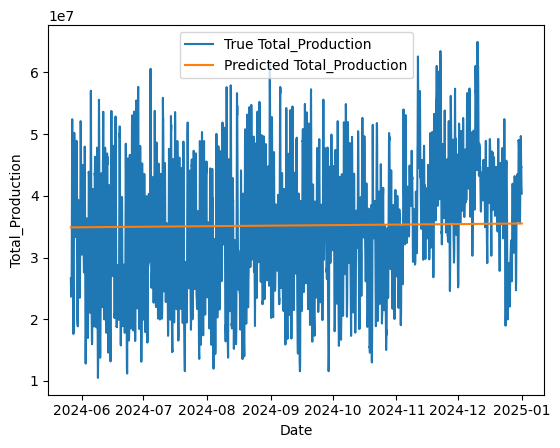

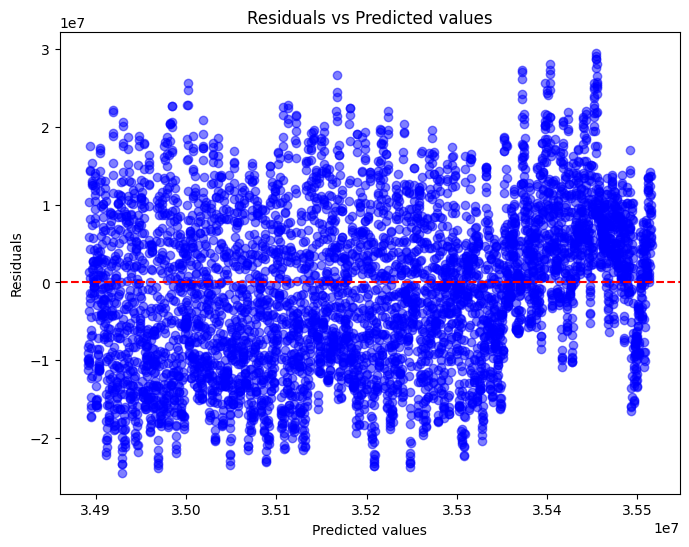

In [17]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Total_Production']  # 'Total_Production' as the target

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['Total_Production']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

aic_lr = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Linear Regression", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

# 2️⃣ ARIMA Model (Example Order: (1,1,1))
arima_model = ARIMA(y_train, order=(1,1,1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
aic_arima = arima_model.aic  # Directly from ARIMA model

# Store results
results.append(["ARIMA (1,1,1)", 
                mean_absolute_error(y_test, y_pred_arima),
                np.sqrt(mean_squared_error(y_test, y_pred_arima)), 
                mean_absolute_percentage_error(y_test, y_pred_arima), 
                symmetric_mape(y_test, y_pred_arima), 
                aic_arima])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()


Predict using LASSO model

In [12]:

# Train Lasso Regression Model
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["LASSO", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])


Mean Absolute Error: 8561186.783027548
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬───────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff      │
│ ---           ┆ ---      ┆ ---       ┆ ---       │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64       │
╞═══════════════╪══════════╪═══════════╪═══════════╡
│ [1716750000]  ┆ 26648506 ┆ 34891493  ┆ -8242987  │
│ [1716753600]  ┆ 25838608 ┆ 34891612  ┆ -9053004  │
│ [1716757200]  ┆ 24997798 ┆ 34891731  ┆ -9893933  │
│ [1716760800]  ┆ 24968287 ┆ 34891849  ┆ -9923562  │
│ [1716764400]  ┆ 23653264 ┆ 34891968  ┆ -11238704 │
│ …             ┆ …        ┆ …         ┆ …         │
│ [1735671600]  ┆ 42375950 ┆ 35515274  ┆ 6860676   │
│ [1735675200]  ┆ 41512334 ┆ 35515392  ┆ 5996942   │
│ [1735678800]  ┆ 41166931 ┆ 35515511  ┆ 5651420   │
│ [1735682400]  ┆ 40696878 ┆ 35515630  ┆ 5181248   │
│ [1735686000]  ┆ 40381524 ┆ 35515748  ┆ 4865776   │
└───────────────┴──────────┴───────────┴───────────┘


Predict using decision tree regression

In [13]:

# Train Decision Tree Regressor Model
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["Decision Tree", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])



Mean Absolute Error: 9952310.113940211
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716750000]  ┆ 26648506 ┆ 27881723  ┆ -1233217 │
│ [1716753600]  ┆ 25838608 ┆ 27881723  ┆ -2043115 │
│ [1716757200]  ┆ 24997798 ┆ 27881723  ┆ -2883925 │
│ [1716760800]  ┆ 24968287 ┆ 27881723  ┆ -2913436 │
│ [1716764400]  ┆ 23653264 ┆ 27881723  ┆ -4228459 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 42375950 ┆ 27881723  ┆ 14494227 │
│ [1735675200]  ┆ 41512334 ┆ 27881723  ┆ 13630611 │
│ [1735678800]  ┆ 41166931 ┆ 27881723  ┆ 13285208 │
│ [1735682400]  ┆ 40696878 ┆ 27881723  ┆ 12815155 │
│ [1735686000]  ┆ 40381524 ┆ 27881723  ┆ 12499801 │
└───────────────┴──────────┴───────────┴──────────┘


Predit using Random Forest regressor

In [14]:

# Train Random Forest Regressor Model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = rf_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

# Store results
results.append(["Random Forest", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr])

Mean Absolute Error: 9944393.835012356
shape: (5_261, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1716750000]  ┆ 26648506 ┆ 27901260  ┆ -1252754 │
│ [1716753600]  ┆ 25838608 ┆ 27901260  ┆ -2062652 │
│ [1716757200]  ┆ 24997798 ┆ 27901260  ┆ -2903462 │
│ [1716760800]  ┆ 24968287 ┆ 27901260  ┆ -2932973 │
│ [1716764400]  ┆ 23653264 ┆ 27901260  ┆ -4247996 │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 42375950 ┆ 27901260  ┆ 14474690 │
│ [1735675200]  ┆ 41512334 ┆ 27901260  ┆ 13611074 │
│ [1735678800]  ┆ 41166931 ┆ 27901260  ┆ 13265671 │
│ [1735682400]  ┆ 40696878 ┆ 27901260  ┆ 12795618 │
│ [1735686000]  ┆ 40381524 ┆ 27901260  ┆ 12480264 │
└───────────────┴──────────┴───────────┴──────────┘


XGBoost Model

XGBoost MAE: 1413420.875


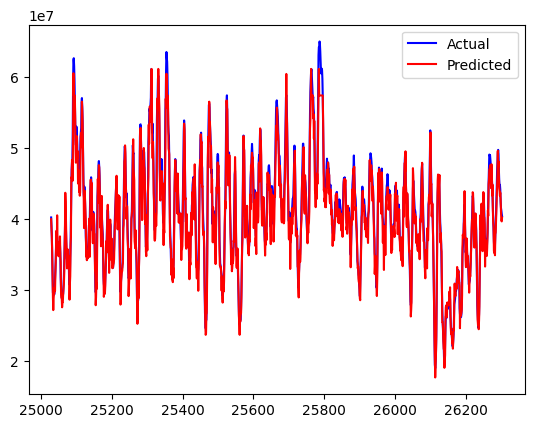

In [15]:
# Create lag features
df['lag1'] = df['Total_Production'].shift(1)
df['lag2'] = df['Total_Production'].shift(2)
df.dropna(inplace=True)

# Train-Test Split
X = df[['lag1', 'lag2']]
y = df['Total_Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE:", mae)

# Plot Results
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Compute evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
smape_xgb = symmetric_mape(y_test, y_pred)
aic_xgb = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

# Append results to results
results.append(["XGBoost", mae_xgb, rmse_xgb, mape_xgb, smape_xgb, aic_xgb])


Print Model evaluation results

In [16]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE", "sMAPE", "AIC"])

# Display Table
print(metrics_df)

               Model           MAE          RMSE       MAPE      sMAPE  \
0  Linear Regression  8.561187e+06  1.029944e+07  30.295352  25.809650   
1      ARIMA (1,1,1)  1.342972e+07  1.624473e+07  34.924665  43.700564   
2              LASSO  8.561187e+06  1.029944e+07  30.295352  25.809650   
3      Decision Tree  9.952310e+06  1.218930e+07  28.308564  30.379127   
4      Random Forest  9.944394e+06  1.217891e+07  28.300008  30.351956   
5            XGBoost  1.413421e+06  1.866486e+06   3.404136   3.466428   

             AIC  
0  169909.045627  
1  657315.150520  
2  169909.045627  
3  169909.045627  
4  169909.045627  
5   36855.777201  
